In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn 
from sklearn.linear_model import LogisticRegression
import scipy.stats as sps
%matplotlib inline
from matplotlib import pylab
pylab.rcParams['figure.figsize']=(12,12)

def shuffler(filename):
    """
    Read into dataframe and shuffle
    """
    df = pd.read_csv(filename, header=0)
    # return the pandas dataframe
    return df.reindex(np.random.permutation(df.index))

In [43]:
phot_df_raw = shuffler('phot_ext_rgilmore.csv')  # main data file retrieved from SkyServer
phot_df_raw.shape

(88943, 370)

# Data Preparation

In [44]:
# Apply some cuts on the data
#Nonphysical model outputs
phot_df = phot_df_raw[phot_df_raw['deVRad_r']>=0.0]
phot_df = phot_df[phot_df['expRad_g']>=0.0]
phot_df = phot_df[phot_df['expAB_g']>=0.]
phot_df = phot_df[phot_df['deVAB_z']>=0.]


# Redshift limits
phot_df = phot_df[(phot_df.z<0.5) & (phot_df.z>0.0)] 



# Remove high extinction cases
phot_df = phot_df[phot_df.extinction_u<=0.5]

# Nonphysical flux params within models
phot_df = phot_df[(phot_df.aperFlux7_g>0)\
                  &(phot_df.cModelFlux_g>0)\
                  &(phot_df.expFlux_u>0)\
                  &(phot_df.modelFlux_u>0)] #check that no negative linear flux params appear
phot_df.reset_index(inplace=True)
phot_df.shape

(85365, 371)

In [45]:
# Extinction corrections to flux

flux_col_lst = [col_name for col_name in phot_df.columns if 'Flux' in col_name]
#print flux_col_list
#print phot_df[flux_col_list][0:10]
             
for flux_col in flux_col_lst:
    band = flux_col[-1]
    phot_df[flux_col+'_ext_cor']=phot_df[flux_col]*2.5**phot_df['extinction_'+band]

In [46]:
phot_df[['psfFlux_u','psfFlux_u_ext_cor','extinction_u']][0:3]

,psfFlux_u,psfFlux_u_ext_cor,extinction_u
0,4.314991,4.885679,0.135561
1,0.485687,0.526596,0.088257
2,1.807525,2.080155,0.153318


In [47]:
# Extinction corrections to magnitude measurements

mag_col_lst = [col_name for col_name in phot_df.columns if 'Mag' in col_name and 'Err' not in col_name]

             
for mag_col in mag_col_lst:
    band = mag_col[-1]
    phot_df[mag_col+'_ext_cor']=phot_df[mag_col]-phot_df['extinction_'+band]
    

In [48]:
phot_df[['deVMag_u','deVMag_u_ext_cor','extinction_u']][0:3]

,deVMag_u,deVMag_u_ext_cor,extinction_u
0,19.08213,18.946569,0.135561
1,23.06981,22.981553,0.088257
2,20.26883,20.115512,0.153318


In [49]:
# remove unextincted columns
print len(phot_df.columns)
for flux_col in flux_col_lst:
    phot_df.drop(flux_col,inplace=True,axis=1)
    
for mag_col in mag_col_lst:
    phot_df.drop(mag_col,inplace=True,axis=1)
print len(phot_df.columns)

501
371


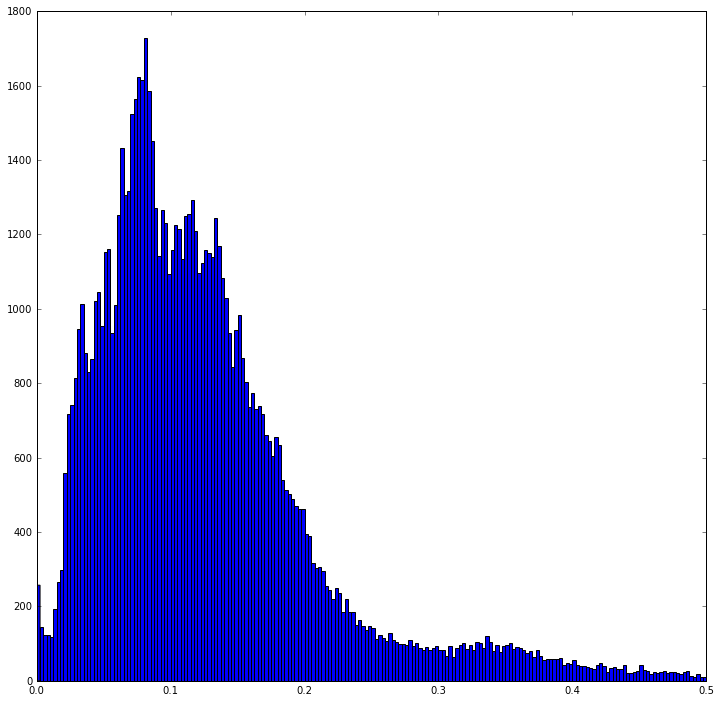

In [50]:
#redshift (distance) distro of galaxy targets
xx=plt.hist(phot_df.z,200)

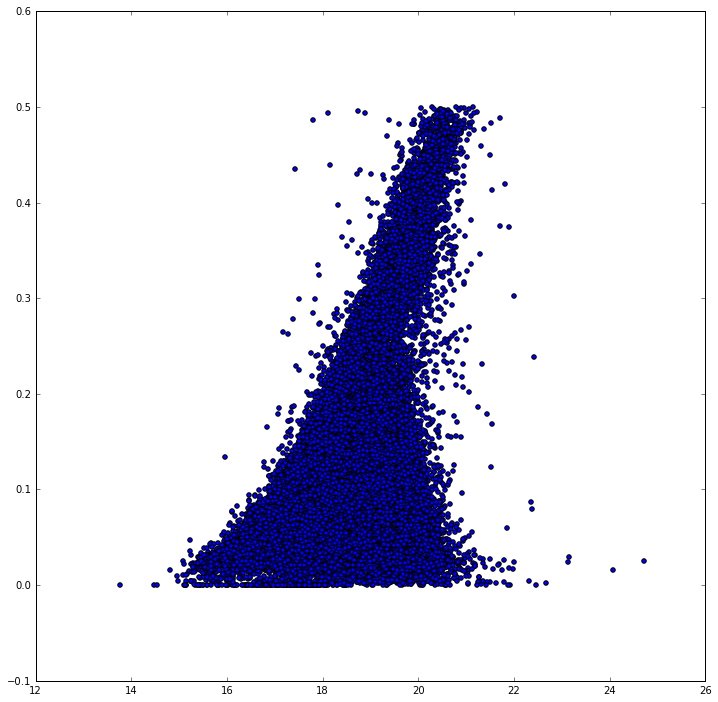

In [51]:
#xx=plt.hist(phot_df.petroMag_r,100)
xx = plt.scatter(phot_df.psfMag_r_ext_cor,phot_df.z)

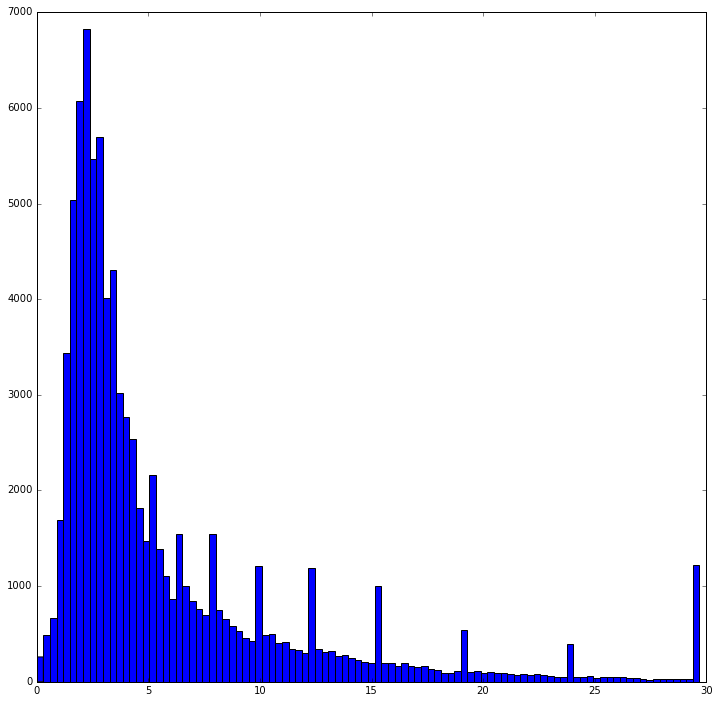

In [52]:
#radius fit distro
xx=plt.hist(phot_df.deVRad_g,100)


In [53]:
# Our target variables - fraction of votes for various galaxy classifications
# p_el: elliptical
# p_cw: clockwise spiral
# p_acw: counter-clockwise spiral
# p_dk: unknown
# p_mg: merger
# p_edge: edge-on spiral 
phot_df[['deVRad_r','p_el', 'p_cw', 'p_acw', 'p_edge', 'p_dk', 'p_mg', 'p_cs']].head()


,deVRad_r,p_el,p_cw,p_acw,p_edge,p_dk,p_mg,p_cs
0,2.548579,0.930,0.012,0.002,0.017,0.039,0.000,0.031
1,1.614075,0.805,0.003,0.018,0.035,0.128,0.013,0.055
2,1.480558,0.699,0.000,0.010,0.086,0.139,0.065,0.097
3,11.713980,0.965,0.002,0.000,0.005,0.025,0.002,0.007
4,2.863721,0.915,0.011,0.008,0.033,0.030,0.003,0.052


(-0.35639567665324895, 0.0)


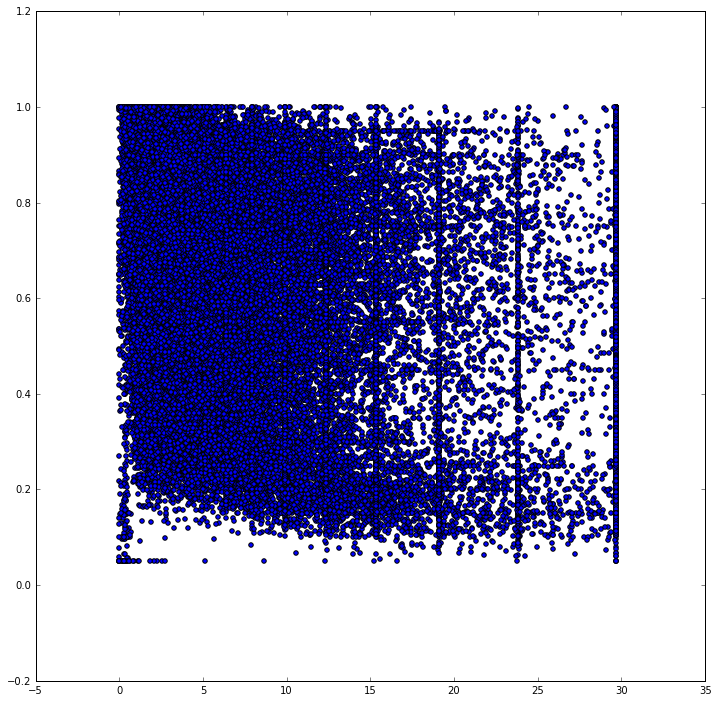

In [54]:
x,y = phot_df['deVRad_g'],phot_df['deVAB_i']
print sps.pearsonr(x,y)
plt.scatter(x,y)

# Logistic Regression

In [55]:
# For the first modeling attempt, let's identify a subset of parameters which are highly 
# correlated with the target variables, and take the top N as the starting set

# Based on experimentation, I find that this method reaches peak accuracy at around N=50 features
# For higher N, accuracy decreases slightly, likely due to overfitting

res=[]
for col in phot_df.columns:
    if 'p_' not in col: res.append([col]+list(sps.pearsonr(phot_df.p_cs,phot_df[col]))) #all independent vars

out = sorted(res,key=lambda x:np.absolute(x[1]),reverse=True)
for item in out[0:50]:
    print item  #variables sorted by declining correlation
    #if 'p_' not in item[0]: print item

['deVRad_g', 0.72697382033133828, 0.0]
['deVRad_r', 0.69263060921868835, 0.0]
['deVRad_i', 0.67852878609926204, 0.0]
['deVRad_z', 0.67444338949538996, 0.0]
['fracDeV_g', -0.66555127811401193, 0.0]
['fracDeV_r', -0.65412898164934241, 0.0]
['fracDeV_i', -0.63377377936897417, 0.0]
['expRad_g', 0.62432872211784962, 0.0]
['expRad_r', 0.58603216465984997, 0.0]
['fracDeV_z', -0.580696247501992, 0.0]
['expRad_i', 0.57649779553643021, 0.0]
['expRad_z', 0.57515337988697679, 0.0]
['fracDeV_u', -0.55719004524555305, 0.0]
['expAB_i', -0.54583176683460988, 0.0]
['expAB_z', -0.54525159464598594, 0.0]
['expAB_r', -0.54340837935255548, 0.0]
['expAB_g', -0.52923958432893337, 0.0]
['deVAB_z', -0.52550665088868098, 0.0]
['deVAB_i', -0.52391789795700761, 0.0]
['deVAB_r', -0.52107628170249332, 0.0]
['deVRad_u', 0.50941131249218641, 0.0]
['deVAB_g', -0.50393881864144918, 0.0]
['deVMag_u_ext_cor', -0.49334667573966723, 0.0]
['expMag_u_ext_cor', -0.48821692671485956, 0.0]
['expFluxIvar_z_ext_cor', -0.435829495

In [56]:
# First attempt at a 2-category classifier: can we distinguish elliptical from non-ellipticals?

# Elliptical galaxies compose roughly half of the training set, so I am not worrying about 
# rebalancing at the moment

input_set = [item[0] for item in out[0:50] if 'p_' not in item[0]]
test_size = 10000

lm = LogisticRegression()
X = np.array(phot_df[input_set][test_size:])
y = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[test_size:]
X_pred = np.array(phot_df[input_set][:test_size])
y_pred = np.array(phot_df['p_el'].apply(lambda x:int(x>0.8)))[:test_size]
lm.fit(X,y)
res_df = phot_df[input_set][0:test_size-1] 
res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(phot_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)


In [57]:
# Results here are encouraging, nearly 90% of the 10000-case sample classified correctly
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

4436 4735 8852
Overall correct fraction =  0.8852


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,deVFluxIvar_r_ext_cor,petroRad_r,petroRad_g,cModelMag_g_ext_cor,petroMag_g_ext_cor,deVFlux_u_ext_cor,cModelFluxIvar_z_ext_cor,actual,pred,cor
0,2.818519,2.548579,2.346887,2.028795,1.00000,1,1,1.576391,1.543333,1,...,0.992972,5.877106,7.126864,17.262856,17.317126,26.367979,0.058698,1,1,1
1,1.232881,1.614075,1.580743,1.427668,0.88109,1,1,0.814247,1.031178,1,...,4.754089,4.142321,2.837454,20.450511,20.418391,0.605586,0.222342,1,0,0
2,1.584836,1.480558,1.301109,0.924960,1.00000,1,1,1.026478,1.025192,1,...,3.733170,4.399189,4.493791,18.652910,18.673220,8.981298,0.217645,0,0,1
3,12.721340,11.713980,11.647900,10.733570,1.00000,1,1,5.874155,6.853486,1,...,0.062441,22.476040,23.527080,15.076435,15.207505,157.180861,0.005094,1,1,1
4,3.155905,2.863721,2.783529,2.480793,1.00000,1,1,1.656565,1.574843,1,...,0.908091,5.421303,5.804179,17.284528,17.376608,18.202865,0.049865,1,1,1


In [58]:
# We can code up a summary confusion matrix to look at counts across predicted and 
# actual categories

imax = max(res_df.actual)
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) 

# rows are actual class, columns are predicted
# 0 = non-elliptical
# 1 = elliptical

,0,1
0,4840,723
1,424,4012


# Multinomial classifier

In [59]:
# Our attempt at binary classification looks encouraging.

# Now, let's attempt to distinguish elliptical, face on- and edge on-spirals, and mergers in a  
# single model, using the softmax regression feature in sklearn's Logistic Regression package.  
# Our target variables will now be an integer representations of the possible classes:
# 
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

# We will use a majority of votes method to determine the training class for a galaxy, 
# discarding ambiguous cases

input_set = [item[0] for item in out[0:30] if 'p_' not in item[0][:2]]
test_size = 10000

ycols = [col for col in phot_df.columns if 'p_' in col[:2]]
def gal_class(row):
    gc_dict = {'p_el':0, 'p_cw':1, 'p_acw':1, 'p_edge':2, 'p_dk':None, 'p_mg':3} #dictionary for our classification
    for item in gc_dict:
        if row[item]>0.65: return gc_dict[item] # We will set a bar of 65% for deciding vote on "correct" class
    return None

phot_df['gal_class'] = phot_df.apply(gal_class,axis=1)
mod_df = phot_df[phot_df.gal_class.notnull()].reset_index()
print len(mod_df)
#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(mod_df[input_set][test_size:])
y = np.array(mod_df['gal_class'])[test_size:]
X_pred = np.array(mod_df[input_set][:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = mod_df[input_set][0:test_size-1]

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(mod_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

65787
3219.0 2447.0 8900
Overall correct fraction =  0.89


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,expMag_u_ext_cor,expFluxIvar_z_ext_cor,lnLDeV_g,deVMag_g_ext_cor,modelMag_u_ext_cor,expFluxIvar_g_ext_cor,lnLDeV_r,actual,pred,cor
0,2.818519,2.548579,2.346887,2.028795,1.00000,1,1,1.576391,1.543333,1,...,19.619429,0.114804,-84.794900,17.262856,19.383819,6.026212,-199.305900,0,0,1
1,1.232881,1.614075,1.580743,1.427668,0.88109,1,1,0.814247,1.031178,1,...,22.989233,0.423759,-0.029159,20.422681,22.569883,27.065754,-0.289762,0,0,1
2,1.584836,1.480558,1.301109,0.924960,1.00000,1,1,1.026478,1.025192,1,...,20.639182,0.329174,-37.330250,18.652910,20.836492,19.188529,-64.035310,0,0,1
3,12.721340,11.713980,11.647900,10.733570,1.00000,1,1,5.874155,6.853486,1,...,17.801437,0.017452,-634.619900,15.076435,17.049387,0.516520,-998.352800,0,2,0
4,3.155905,2.863721,2.783529,2.480793,1.00000,1,1,1.656565,1.574843,1,...,19.605081,0.109985,-41.882240,17.284528,19.216241,6.340792,-93.268810,0,0,1


In [60]:
# Our success rate in the first-try multinomial model above is fairly high overall.  
# However, our classes are not balanced (most galaxies in sample are elliptical).
# And we are not correctly identifying any of the small number of merger cases that appear
# (class = 3)

print len(res_df)
print 'Class count in test set:'
print res_df.actual.value_counts()
res_df[res_df['actual']==3]

9999
Class count in test set:
0    7752
1    1307
2     908
3      32
Name: actual, dtype: int64


,deVRad_g,deVRad_r,deVRad_i,deVRad_z,fracDeV_g,fracDeV_r,fracDeV_i,expRad_g,expRad_r,fracDeV_z,...,expMag_u_ext_cor,expFluxIvar_z_ext_cor,lnLDeV_g,deVMag_g_ext_cor,modelMag_u_ext_cor,expFluxIvar_g_ext_cor,lnLDeV_r,actual,pred,cor
166,12.560650,10.270730,9.567334,9.169669,0.573141,0.751087,0.840145,6.117905,5.782674,1.000000,...,17.521175,0.025341,-3821.456000,15.502786,17.417055,0.691834,-5040.66600,3,1,0
263,7.312759,7.939163,8.098401,9.893099,0.000000,0.031091,0.031117,4.072709,4.166236,0.004904,...,16.703542,0.024411,-9038.763000,15.456436,16.643562,0.594435,-8390.90800,3,1,0
363,6.731761,6.699277,6.011037,5.554335,0.159050,0.264422,0.337970,3.099596,3.102630,0.410543,...,20.390075,0.069210,-321.077500,17.321305,20.181045,4.831824,-1101.52100,3,0,0
867,7.941263,8.019423,8.468210,9.799077,0.112714,0.160053,0.166368,3.834180,3.858619,0.109853,...,17.979244,0.042080,-2359.941000,16.194050,17.846954,1.681714,-2911.94700,3,1,0
1011,6.190080,6.373897,5.867348,6.373719,0.040067,0.158520,0.189875,3.219748,3.158849,0.235991,...,20.070308,0.106908,-369.199400,17.863200,20.000868,7.021210,-727.83010,3,0,0
1241,4.958196,4.275159,4.175169,4.869287,0.065312,0.166176,0.219599,2.595887,2.490453,0.343211,...,17.857309,0.061937,-3861.732000,16.339850,17.908059,2.267866,-4391.81200,3,1,0
1262,7.859071,6.257401,5.729597,4.650141,1.000000,1.000000,1.000000,5.514565,4.401240,1.000000,...,17.991412,0.020087,-2962.168000,15.274217,17.671792,0.617538,-3793.00500,3,1,0
1838,1.793868,2.174252,1.926275,1.891646,0.718259,0.636582,0.675949,1.295261,1.336613,0.333105,...,19.544053,0.143158,-16.152310,17.998647,19.136583,9.356932,-67.67579,3,0,0
2271,0.317915,45.485770,36.802390,29.663210,1.000000,1.000000,0.000000,1.393044,41.520960,1.000000,...,17.344738,0.000003,0.000000,25.012960,17.344838,0.081378,0.00000,3,2,0
2815,1.251884,1.590851,1.430534,1.579295,0.818113,0.851795,0.812504,0.973154,1.027773,0.898401,...,18.254377,0.189075,-276.256100,17.378194,17.907297,6.922881,-299.79800,3,0,0


In [61]:
# As before, let's look at the confusion matrix to look at counts predicted vs actual
# Classes:
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) 

# rows are actual class, columns are predicted

/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,7613,63,76,0
1,313,811,183,0
2,344,88,476,0
3,20,9,3,0


In [ ]:
# It looks as though a substantial number of spiral galaxies (N=1 and 2) are being  
# misclassified as elliptical, which is the more prevalent class.  
# All mergers (N=3) are being misclassified.

# Maybe we can use resampling to balance out the training cases before building the model...

# Classification with resampling

In [62]:
# Let's see if we can improve performance by using resampling to increase representation of 
# less-common galaxy types in the training set

# first, lets fix a shortcoming of the first multimode classifier, which was still using a feature  
# list derived for the binary classifier, and only looking at correlation with elliptical votes;
# let's update to take the max of several correlations

res=[]
for col in phot_df.columns:
    if 'p_' not in col: res.append([col]\
                                   +list(sps.pearsonr(phot_df.p_cw,phot_df[col]))\
                                   +list(sps.pearsonr(phot_df.p_el,phot_df[col]))\
                                   +list(sps.pearsonr(phot_df.p_mg,phot_df[col]))) #all independent vars

out = sorted(res,key=lambda x:max([np.absolute(x[1]),np.absolute(x[3]),np.absolute(x[5])]),reverse=True)
for item in out[0:50]:
    print item  #variables sorted by declining correlation

input_set = [item[0] for item in out[0:50] if 'p_' not in item[0]]
mod_df = phot_df[phot_df.gal_class.notnull()].reset_index()

# next, I'll manually select some weights to place on the different classes, then use Panda's 
# sample method to construct a new dataframe

weights = {0:1,1:6,2:8,3:200}
mod_df['rs_weights'] = mod_df.apply(lambda row:weights[row['gal_class']],axis=1)
mod_rs_df = mod_df.sample(50000,replace=True,weights=mod_df.rs_weights).reset_index(drop=True)

['fracDeV_g', -0.29058614911398994, 0.0, 0.6921983552762172, 0.0, -0.01985719021125722, 6.5442693420474347e-09]
['deVRad_g', 0.35505521853438837, 0.0, -0.68282720730386537, 0.0, -0.036564346794189691, 1.1769497916922989e-26]
['fracDeV_r', -0.26944598846008705, 0.0, 0.68102006263014692, 0.0, -0.016257841797036765, 2.0306984005345621e-06]
['fracDeV_i', -0.25058523789270398, 0.0, 0.66099113895277273, 0.0, -0.015043956659306258, 1.1045665891642282e-05]
['deVRad_r', 0.33242706416627799, 0.0, -0.65707546741538858, 0.0, -0.028405840161803083, 1.0326486536944963e-16]
['deVRad_i', 0.32797418929847161, 0.0, -0.64195006975406177, 0.0, -0.027041744210223172, 2.7403664924372629e-15]
['deVRad_z', 0.32390783457743794, 0.0, -0.63798034427197292, 0.0, -0.030671938119013122, 3.1457133340157582e-19]
['fracDeV_z', -0.21602770064289506, 0.0, 0.61867559314194176, 0.0, -0.026765732595845266, 5.2194180831771675e-15]
['expRad_g', 0.30136048533283033, 0.0, -0.59459181027810259, 0.0, -0.035774512022504049, 1.382

In [63]:
# let's rerun the analysis after training on the resampled set

#input_set = [item[0] for item in out[0:30] if 'p_' not in item[0][:2]]
test_size = 10000

print len(mod_rs_df)
#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(mod_rs_df[input_set][test_size:])
y = np.array(mod_rs_df['gal_class'])[test_size:]
X_pred = np.array(mod_df[input_set][:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = mod_rs_df[input_set][0:test_size-1]

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(mod_df[input_set][0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

50000
3219.0 5750.0 8042
Overall correct fraction =  0.8042


,fracDeV_g,deVRad_g,fracDeV_r,fracDeV_i,deVRad_r,deVRad_i,deVRad_z,fracDeV_z,expRad_g,fracDeV_u,...,expFluxIvar_g_ext_cor,deVMag_g_ext_cor,deVFlux_u_ext_cor,expMag_g_ext_cor,petroRad_g,fiber2Mag_r_ext_cor,z,actual,pred,cor
0,0.000000,12.317930,0.000000,0.000000,9.889244,9.086150,8.345079,0.00000,5.417314,0,...,1.467655,16.762501,44.052899,17.118691,7.677796,18.966580,0.043587,0,0,1
1,1.000000,2.748847,1.000000,1.000000,2.413873,2.340684,2.265782,1.00000,1.567726,1,...,6.598605,17.459100,20.636265,17.861420,5.696524,18.542143,0.107560,0,3,0
2,0.583291,8.144591,0.349724,0.598952,5.816084,6.231259,5.115046,0.64044,3.617977,0,...,7.004402,17.698160,9.837479,18.137090,6.469973,19.323809,0.096189,0,0,1
3,0.000000,1.106592,0.000000,0.000000,1.098963,0.959918,0.942333,0.00000,0.912620,1,...,12.571660,18.699361,2.621114,18.831821,2.299999,18.942378,0.087762,0,0,1
4,1.000000,2.477686,1.000000,1.000000,2.301013,2.206827,1.954369,1.00000,1.511336,1,...,10.587355,18.441697,9.574482,18.795437,4.684728,19.501390,0.100790,0,0,1


In [64]:
# Unfortunately, overall accuracy is down, though we are able to pick up many of the merger cases
# This may or may not be a worthwhile tradeoff, depending on what our overall goal is
print len(res_df)
print res_df.actual.value_counts()
res_df[res_df['actual']==3]

9999
0    7752
1    1307
2     908
3      32
Name: actual, dtype: int64


,fracDeV_g,deVRad_g,fracDeV_r,fracDeV_i,deVRad_r,deVRad_i,deVRad_z,fracDeV_z,expRad_g,fracDeV_u,...,expFluxIvar_g_ext_cor,deVMag_g_ext_cor,deVFlux_u_ext_cor,expMag_g_ext_cor,petroRad_g,fiber2Mag_r_ext_cor,z,actual,pred,cor
166,0.717212,2.940557,0.932047,1.000000,2.679756,2.766071,2.029882,1.000000,1.638167,0.000000,...,6.333846,17.586729,11.116547,17.971199,5.166017,18.725587,0.102298,3,3,1
263,0.318288,7.201929,0.230645,0.428023,7.318970,6.074058,7.460191,0.350046,3.949730,1.000000,...,4.543920,17.336736,40.356270,17.675196,6.734111,19.426438,0.102254,3,1,0
363,0.000000,15.355510,0.000000,0.000000,15.352960,15.351270,15.354580,0.013564,6.268068,0.000000,...,1.607556,16.434399,113.037695,16.859049,9.325549,19.698901,0.057433,3,3,1
867,1.000000,5.803886,1.000000,1.000000,5.920506,5.754169,4.392871,1.000000,3.555619,1.000000,...,0.503626,15.088230,152.685630,15.557800,16.871460,16.896179,0.029821,3,3,1
1011,0.000000,16.349600,0.000000,0.027798,15.349750,15.447710,17.452160,0.062294,6.593308,0.000000,...,1.035562,15.912493,180.938609,16.354383,9.674854,19.166269,0.047730,3,3,1
1241,0.075056,24.907900,0.123616,0.117243,23.819670,23.815450,24.448400,0.197838,9.387571,0.000000,...,0.317466,15.018878,384.049449,15.541808,17.127680,19.281560,0.024614,3,3,1
1262,1.000000,2.699520,1.000000,1.000000,2.901767,2.700522,2.568494,1.000000,1.589764,1.000000,...,9.493425,18.243580,7.374698,18.578990,5.566939,19.068358,0.178933,3,3,1
1838,1.000000,2.664938,1.000000,1.000000,2.533591,2.491115,2.013384,1.000000,1.536320,1.000000,...,13.676961,18.623287,22.691908,18.992777,5.260222,19.184969,0.239132,3,3,1
2271,0.091871,28.664020,0.050821,0.087072,23.826890,16.677420,22.877510,0.165537,10.702100,0.233626,...,1.881342,16.828328,49.865805,17.397598,15.538140,20.155508,0.035076,3,3,1
2815,0.739246,4.405424,0.924393,1.000000,3.426312,3.323353,2.901511,1.000000,2.483638,0.000000,...,6.799768,17.807893,30.693164,18.190853,5.749047,19.231804,0.118640,3,3,1


In [65]:
# We can compare the error matrix here to the unsampled set, definitely improvement in the 
# last two classes
# Classes:
# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) 

# rows are actual class, columns are predicted

/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,6841,185,202,524
1,66,686,348,207
2,199,66,490,153
3,3,2,2,25


In [ ]:
# The resampled model is less accurate overall, 
# but it does correctly classify most of the merger cases in the test set. 


# Regression with a PCA transform

In [66]:
# To avoid having to select features by hand, and avoid problems with collinearity and 
# overfitting, it makes sense to run the feature set through a PCA transform, and just 
# model based on a few variables.

# Let's see if this improves performance over our previous method of selecting variables 
# based on correlation

from sklearn.decomposition import PCA
pca = PCA(n_components=5)


#rescale and center input params
mod_df_rescale = mod_df.copy()
for col in input_set:
    s = np.std(mod_df[col])
    m = np.mean(mod_df[col])
    mod_df_rescale[col] = mod_df[col].apply(lambda x:(x-m)/s)
    
# run PCA on a subset of our data - doing the full set gets expensive
pca.fit(mod_df_rescale[input_set][0:10000])
print(pca.explained_variance_ratio_) 
pca_df = pca.transform(mod_df_rescale[input_set]) #apply transform to full set
print pca_df.shape


# and rerun our logistic regression model, using the new PCA components as the training set

test_size = 10000


#print mod_df[ycols+['gal_class']]
lm = LogisticRegression(multi_class='multinomial',solver='lbfgs')
X = np.array(pca_df[test_size:])
y = np.array(mod_df['gal_class'])[test_size:]
X_pred = np.array(pca_df[:test_size])
y_pred = np.array(mod_df['gal_class'])[:test_size]


lm.fit(X,y)
res_df = pd.DataFrame(pca_df[0:test_size-1])

res_df['actual'] = pd.Series(y_pred)
res_df['pred'] = pd.Series(lm.predict(pca_df[0:test_size]))
res_df['cor'] = res_df.apply(lambda row:int(row['actual']==row['pred']),axis=1)
print sum(res_df['actual']),sum(res_df['pred']),sum(res_df['cor'])
print 'Overall correct fraction = ',sum(res_df['cor'])/float(test_size)
res_df.head()

# I've printed out the explained variance ratios below.  The rapid falloff in the 
# numbers means that the first few variables contain most of the model's explanatory power

[ 0.41075225  0.25792565  0.10767951  0.05235836  0.03059819]
(65787, 5)
3219.0 3027.0 9466
Overall correct fraction =  0.9466


,0,1,2,3,4,actual,pred,cor
0,-1.469380,-3.104416,0.385261,0.463187,0.375445,0,0,1
1,-6.241070,5.594945,-1.451706,-2.847640,-1.608272,0,0,1
2,-3.773945,0.581843,-0.037762,-0.732131,-0.065418,0,0,1
3,5.462022,-6.169216,-2.233695,-1.235586,3.385548,0,0,1
4,-0.793367,-1.568792,2.384675,-0.152207,-0.012354,0,0,1


In [67]:
pca.components_[:2]

array([[-0.14552287,  0.19919598, -0.14870563, -0.14760257,  0.20171362,
         0.20097207,  0.19966771, -0.13829329,  0.19988327, -0.10860305,
         0.20418674, -0.12128487,  0.19731205, -0.12277876, -0.12273019,
         0.20342193, -0.11667788, -0.11195544, -0.11161629, -0.11145057,
        -0.10452733,  0.12726045, -0.17658919, -0.14377765, -0.17567455,
        -0.14743148, -0.01421118, -0.0168555 ,  0.17749493, -0.14052715,
        -0.02843753,  0.00367838, -0.03247485, -0.16202773, -0.13960988,
        -0.16813899, -0.08351002,  0.16223154, -0.16590764, -0.03775639,
         0.01476099, -0.11427264, -0.04311794, -0.14851774, -0.17170208,
         0.15749853, -0.17049428,  0.14902631, -0.04561027, -0.13878281],
       [-0.13857865,  0.06466264, -0.13880496, -0.14184965,  0.06400574,
         0.05938345,  0.06100286, -0.14631912,  0.02547645, -0.12022766,
         0.01759526, -0.13600858,  0.03809129, -0.12978571, -0.13166859,
         0.01430835, -0.1412465 , -0.14491311, -0.

In [68]:
# Let's look at the usual confusion matrix

print len(res_df)
print res_df.actual.value_counts()

# 0 - Ellipticals
# 1 - Spirals (face-on)
# 2 - Spirals (edge-on)
# 3 - Mergers

imax = int(max(res_df.actual))
rep = np.zeros((imax+1,imax+1),dtype=np.int32)
for i in range(len(res_df)):
    rep[res_df.actual[i]][res_df.pred[i]]+=1
pd.DataFrame(rep) 

# rows are actual class, columns are predicted

9999
0    7752
1    1307
2     908
3      32
Name: actual, dtype: int64


/Users/rudygilmore/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


,0,1,2,3
0,7599,148,5,0
1,276,988,43,0
2,15,14,879,0
3,15,11,6,0


In [ ]:
# Performance here is impressive compared to previous cases, with a much smaller features subset.
# ~95% accuracy with first 5 PCA features

# Unfortunately, we are back to misclassifying our merger cases, so the next step would be to try  
# to boost these cases in the training set with resampling, if recovering those is a priority.

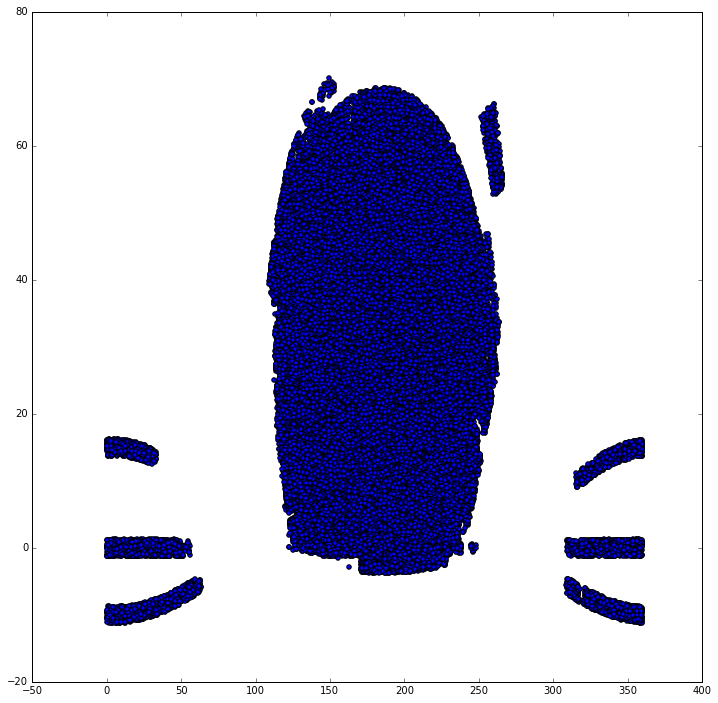

In [69]:
# positions of galaxy targets on the sky (not essential to this project, but interesting)
plt.scatter(phot_df.ra,phot_df.dec)